In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdDepictor
import matplotlib.pyplot as plt

In [29]:
protein_name = 'egfr'

## Load the datasets
### Load the ensemble docking results

In [30]:
# Load the dataset
file_name = '../4_Ensemble_docking_results/' + \
            'df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
df_dk_res = pd.read_pickle(file_name)

# Extract the features columns: Docking scores
X = df_dk_res.drop('activity', axis = 1)
# Extract the response variable: Activity
y = df_dk_res['activity']

### Load the molecules saved as `rdkit` objects

In [31]:
# Load the dataframe with the rdkit molecules (no duplicates)
rdk_mols_file = '../2_Molecular_libraries/df_MOLECULES_no_duplicates.obj'
df_rdk_mols = pd.read_pickle(rdk_mols_file)
df_rdk_mols = df_rdk_mols.replace({'DEKOIS2': 'DEKOIS'})
df_rdk_mols = df_rdk_mols.set_index(['library', 'Lig'])

In [32]:
# Verify that both datasets match
assert np.all(X.index == df_rdk_mols.index)

## Load the `30x4cv` results
- This analysis was performed in the `2_30x4CV_analysis.ipynb` notebook.
- It contains the performance of the SBVS methods (ML and consensus strategies) of the 30x4cv analysis
- It also includes the information of each of the $120 \times 4$ validation sets:
    - The indices of the molecules used at each validation set.
    - The predictions of each of the SBVS methods:
        - The probabilities (*logits*) of the ML methods
        - The aggregation value determined by the consensus strategy.

In [33]:
n_repeats = 30
n_splits  = 4
evaluation_name = f'{n_repeats}x{n_splits}cv'
filename = f'./cachedir/{evaluation_name}_{protein_name}'
cv30x4, y_preds, splits = joblib.load(filename)

#******************
#      NOTES
#******************

# cv30x4:  Are the results, per metric and per method, of the 30x4cv 

# y_preds: Is a dictionary where the key corresponds to the method's name
#          and the value is a list with the 120 predictions of the method
#          over the validation set. Each element of the list, is a numpy array
#.         with the predicions of the 25% of the molecules used for that
#          validation set. For the ML models, the values are the probabilities
#          returned by the classifier. For the Consensus scorings, the values
#.         are those resulting from the aggregation method applied over the raw
#          docking scores.

# splits:  is a list of 120 elements, where each element is a tuple where 
#          the second element is anumpy array with
#.         the indices of the molecules used for the validation sets.

# Therefore, each array inside y_preds contains the predictions of the method.

### Determine the rankings of each SBVS method after `30x4cv` analysis

In [34]:
def combine_cv_results(set_preds, k):
    '''
    Take `set_preds` which is a list of nxk elements,
    where each element is an array containing
    the indices of the samples comprising each validation
    set. 
    
    Returns a list of size 
    '''
    assert len(set_preds) % k == 0
    chunks = []
    for i in range(0, len(set_preds), k):
        chunks.append( set_preds[i: i+k])
    return chunks

In [35]:
# Number of validations sets = 120
n_val_sets   = n_repeats * n_splits
# Get only the validation sets
val_sets_ids = [i[1] for i in splits]

# List of results per method
m_preds_ranks = {}

for m_name in y_preds.keys():
    # Just get the validation set indices from the tuples
    # insidet the `splits` list
    set_preds = [
        pd.DataFrame(y_preds[m_name][i], 
                     index=val_set).rank(ascending=False)
         for i, val_set in enumerate(val_sets_ids)
    ]

    # Every k elements belong to 1 repeat of CV,
    # therefore, we can get the predictions per repeat
    # of all molecules using the `every_k_
    chunks = combine_cv_results(set_preds, k=n_splits)

    final_ranks = pd.concat([pd.concat(chunk, axis=0) 
                             for chunk in chunks], 
                            axis   = 1,
                            levels = None,
                            keys = range(1, n_repeats + 1))
    final_ranks.columns = final_ranks.columns.droplevel(1)
    final_ranks.columns.name = 'Repeats'
    final_ranks.index.name   = 'Molecules'

    # Add the labels: the y_true values
    mean_ranks = final_ranks.mean(axis = 1).to_frame(name='mean_rank')
    # Add the dataframe to the dictionary `m_preds_ranks`
    m_preds_ranks[m_name] = mean_ranks
# Convert the dictionary to a DataFrame
df_rank_preds = pd.concat(m_preds_ranks.values(), 
                          axis = 1, 
                          keys = y_preds.keys())
# For a better visualization of the table, let's format it
df_rank_preds.columns = df_rank_preds.columns.droplevel(1)
df_rank_preds = df_rank_preds.rank().astype('int')
Activities_list = ['Active' if i else 'Inactive' for i in y.values]
df_rank_preds.insert(loc = 0, column = 'Activity', value = Activities_list)
df_rank_preds.index = y.index
df_rank_preds.index.names = ['Library', 'Lig. Name']
df_rank_preds.columns.names = ['Ranking']
# Update the name of the columns
df_rank_preds = df_rank_preds.rename(columns = {'ml_lr'  : 'LR',
                      'ml_xgb' : 'GBT',
                      'ml_dclf': 'Dcfl',
                      'cs_MEAN': 'csAVG',
                      'cs_GEOM': 'csGEOM',
                      'cs_MIN' : 'csMIN'})

## Correlations between ranks

In [36]:
methods = ['LR','GBT','csAVG','csGEOM','csMIN']
# Correlation over the full set
df_corr = df_rank_preds[methods].corr(method = 'kendall').round(3)
df_corr

Ranking,LR,GBT,csAVG,csGEOM,csMIN
Ranking,,,,,
LR,1.000,0.578,0.274,0.279,0.188
GBT,0.578,1.000,0.209,0.212,0.150
csAVG,0.274,0.209,1.000,0.979,0.633
csGEOM,0.279,0.212,0.979,1.000,0.618
csMIN,0.188,0.150,0.633,0.618,1.000


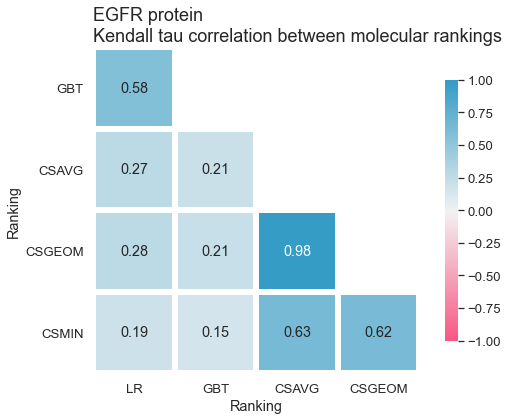

In [43]:
sns.set(style='whitegrid', font_scale = 1.2)
fig, ax = plt.subplots(figsize=(9, 6))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
# title
title = f'{protein_name.upper()} protein\n' +\
        'Kendall tau correlation between molecular rankings'
plt.title(title, loc='left', fontsize=18)
plt.savefig(f'{protein_name}_rankings.pdf')
plt.show()

## Draw the  top $k$ molecules of each SBVS method

In [38]:
# Define a function to draw the top molecules

def draw_top_mols_by_method(method, n_mols=9, 
                            subImgSize = (300, 220),
                            alignSubstructure = False):
    '''
    `df_rank_preds` and `df_rdk_mols` should be created. 
    '''
    # Get the top molecules by the given method
    df_top_mols_by_method = df_rank_preds.sort_values(method).head(n_mols)
    # Drop the Dummy classifier for simplicity
    df_top_mols_by_method = df_top_mols_by_method.drop('Dcfl', axis = 1)
    idx = (df_top_mols_by_method).index
    mols_rows = df_rdk_mols.loc[idx]
    # Verify the indices match
    assert np.all(df_top_mols_by_method.index == mols_rows.index)
    # Add extra data => MW, num atoms, num rot
    df_top_mols_by_method = pd.concat([df_top_mols_by_method, 
                                       mols_rows[['MW','num_atoms','num_rot']]], 
                                      axis = 1)
    # Get the mol objects
    mols = mols_rows['mol_rdk'].to_list()

    # Create the molecular labels
    mols_labels = [ f'{name} ({lib})' for lib, name
                    in mols_rows.index]
    mols_labels = [f'{ac} - {lb}' for ac, lb in 
                   zip(df_top_mols_by_method['Activity'], mols_labels)]
    # Convert to 2D for visualization
    for i in mols: AllChem.Compute2DCoords(i, canonOrient=True)

    # Get the common cores
    match_all = rdFMCS.FindMCS(mols, completeRingsOnly = False,
                               bondCompare=Chem.rdFMCS.BondCompare.CompareAny)
    # Convert to mol objects
    mcs_all = Chem.MolFromSmarts(match_all.smartsString)
    if alignSubstructure:
        # Aling molecules to the Maximum common substructure
        AllChem.Compute2DCoords(mcs_all)
        subms = [x for x in mols 
                     if x.HasSubstructMatch(
                      mcs_all
                     )]
        for m in mols:
            _ = AllChem\
            .GenerateDepictionMatching2DStructure(m, mcs_all)

    # Draw the molecules
    rdDepictor.SetPreferCoordGen(False)
    img = Chem.Draw.MolsToGridImage(
         mols,
         molsPerRow = 3,
         legends = mols_labels,
         useSVG=True,
         highlightAtomLists=[ mol.GetSubstructMatch(mcs_all) for mol in mols], 
         subImgSize = subImgSize)
    return img, df_top_mols_by_method

### Logistic Regression

Activity  LR  GBT  csAVG  csGEOM  csMIN       MW  \
Library Lig. Name                                                      
DUD     ligand_169    Active   1   99   1113    1236    509  347.406   
DEKOIS  decoy_45    Inactive   2  165    100     103    136  559.683   
DUD     ligand_83     Active   3  118   1429    1566    229  412.275   
        ligand_435    Active   4  267   3083    3212   2061  573.573   
COCRYS  QP1           Active   5  282     62      60     40  522.626   
        QQM           Active   6  164      9       7     28  490.559   
DUD     ligand_276    Active   7   27    745     698    734  411.327   
        ligand_454    Active   8  181    244     274     79  481.327   
        ligand_308    Active   9  220   1445    1506   1413  444.373   

                    num_atoms  num_rot  
Library Lig. Name                       
DUD     ligand_169         26        6  
DEKOIS  decoy_45           41       10  
DUD     ligand_83          26        6  
        ligand_435         39        8  
COCRYS  QP1                37       10  
        QQM                36       10  
DUD     ligand_276         26        5  
        ligand_454         30        9  
        ligand_308         28       10

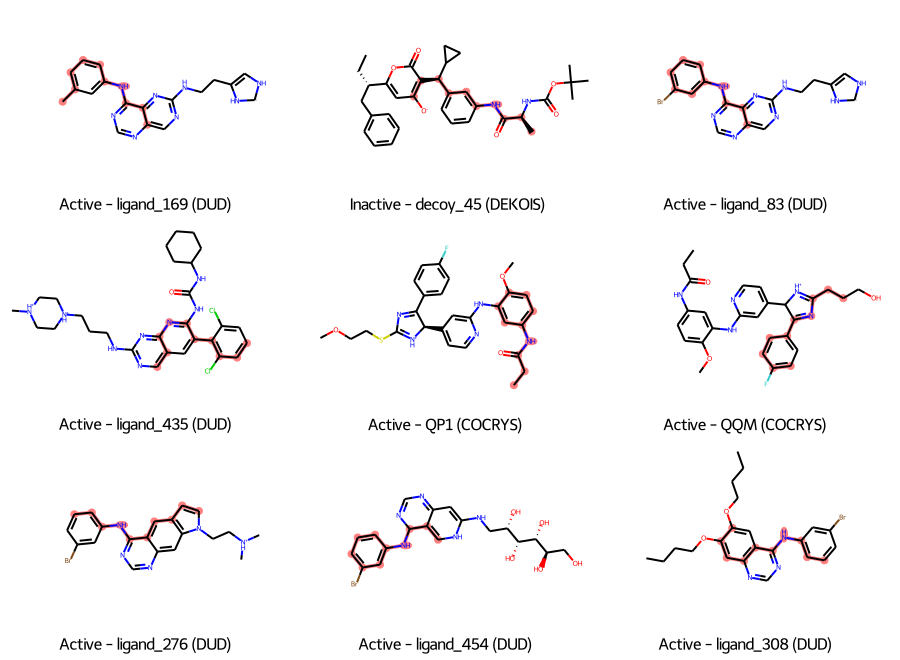

In [39]:
# Define the method
method = 'LR'
n_mols = 9

img, df_top = draw_top_mols_by_method(method, n_mols=n_mols)

display(df_top)
display(img)

### Gradient Boosting Trees

Activity   LR  GBT  csAVG  csGEOM  csMIN       MW  \
Library Lig. Name                                                      
DUD     ligand_24    Active  133    1   9389    9203   9334  255.708   
        ligand_226   Active  124    2   7767    7507   8786  330.185   
        ligand_247   Active  225    3   8692    8514  10269  335.592   
        ligand_71    Active  232    4   8187    7953  10432  331.197   
        ligand_18    Active  225    5   9448    9264   9125  235.290   
        ligand_27    Active  323    6  10200    9998   9901  300.159   
        ligand_140   Active  279    7   6589    6429   8893  266.328   
        ligand_185   Active  111    8   7103    6905   6434  329.201   
        ligand_162   Active  107    9  10086    9832  11624  331.173   

                    num_atoms  num_rot  
Library Lig. Name                       
DUD     ligand_24          18        2  
        ligand_226         20        3  
        ligand_247         19        2  
        ligand_71          20        3  
        ligand_18          18        2  
        ligand_27          18        2  
        ligand_140         20        3  
        ligand_185         20        3  
        ligand_162         20        3

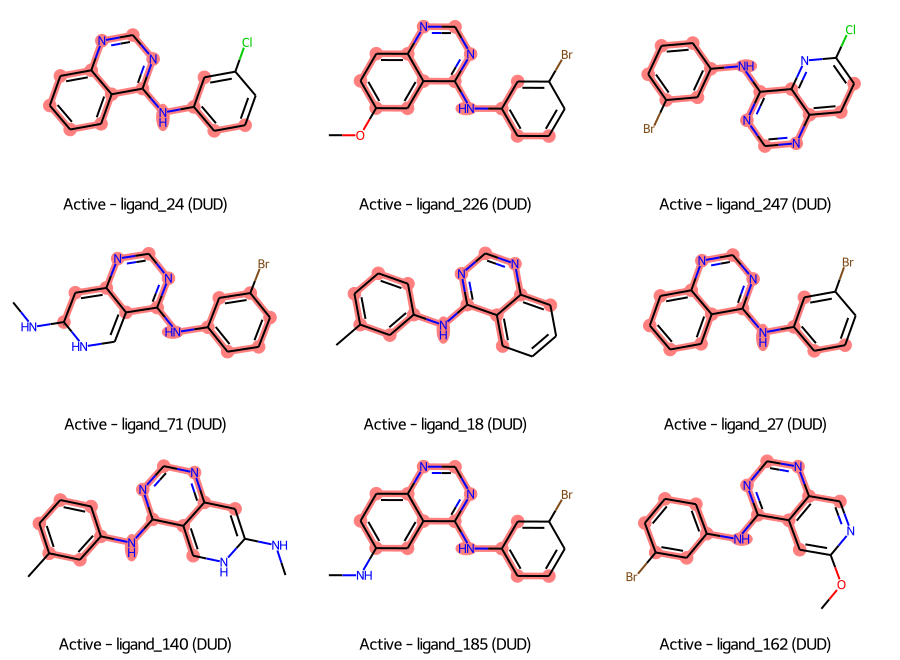

\begin{tabular}{lllrrrrrrrr}
\toprule
    &            & Activity &   LR &  GBT &  csAVG &  csGEOM &  csMIN &     MW &  num\_atoms &  num\_rot \\
Library & Lig. Name &          &      &      &        &         &        &        &            &          \\
\midrule
DUD & ligand\_24 &   Active &  133 &    1 &   9389 &    9203 &   9334 &  255.7 &         18 &        2 \\
    & ligand\_226 &   Active &  124 &    2 &   7767 &    7507 &   8786 &  330.2 &         20 &        3 \\
    & ligand\_247 &   Active &  225 &    3 &   8692 &    8514 &  10269 &  335.6 &         19 &        2 \\
    & ligand\_71 &   Active &  232 &    4 &   8187 &    7953 &  10432 &  331.2 &         20 &        3 \\
    & ligand\_18 &   Active &  225 &    5 &   9448 &    9264 &   9125 &  235.3 &         18 &        2 \\
    & ligand\_27 &   Active &  323 &    6 &  10200 &    9998 &   9901 &  300.2 &         18 &        2 \\
    & ligand\_140 &   Active &  279 &    7 &   6589 &    6429 &   8893 &  266.3 &         20 &    

In [40]:
# Define the method
method = 'GBT'
n_mols = 9

img, df_top = draw_top_mols_by_method(method, n_mols=n_mols)

display(df_top)
display(img)

# Save for supplementary material
filename = f'{protein_name}_{n_mols}_topMols_{method}.svg'
with open(filename, 'w') as f:
    f.write(img.data)
    
print(df_top.round(1).to_latex())

### Average Consensus strategy (csAVG)

Activity    LR  GBT  csAVG  csGEOM  csMIN       MW  \
Library Lig. Name                                                        
DEKOIS  decoy_85    Inactive  1722  243      1       2      3  493.444   
        decoy_1077  Inactive   205  310      2       1     19  650.742   
COCRYS  N7Q           Active  1511  215      3       3      6  563.058   
DEKOIS  decoy_36    Inactive  4575  546      4       4     14  591.664   
        decoy_1067  Inactive   273  261      5       5     50  522.581   
COCRYS  N7B           Active  2084  250      6       8      7  551.651   
        03P           Active  1517  313      7       9      8  547.965   
        W19           Active   333  426      8       6      2  512.035   
        QQM           Active     6  164      9       7     28  490.559   

                    num_atoms  num_rot  
Library Lig. Name                       
DEKOIS  decoy_85           36        8  
        decoy_1077         46        7  
COCRYS  N7Q                40       10  
DEKOIS  decoy_36           44       13  
        decoy_1067         39        6  
COCRYS  N7B                41        9  
        03P                38        9  
        W19                35        6  
        QQM                36       10

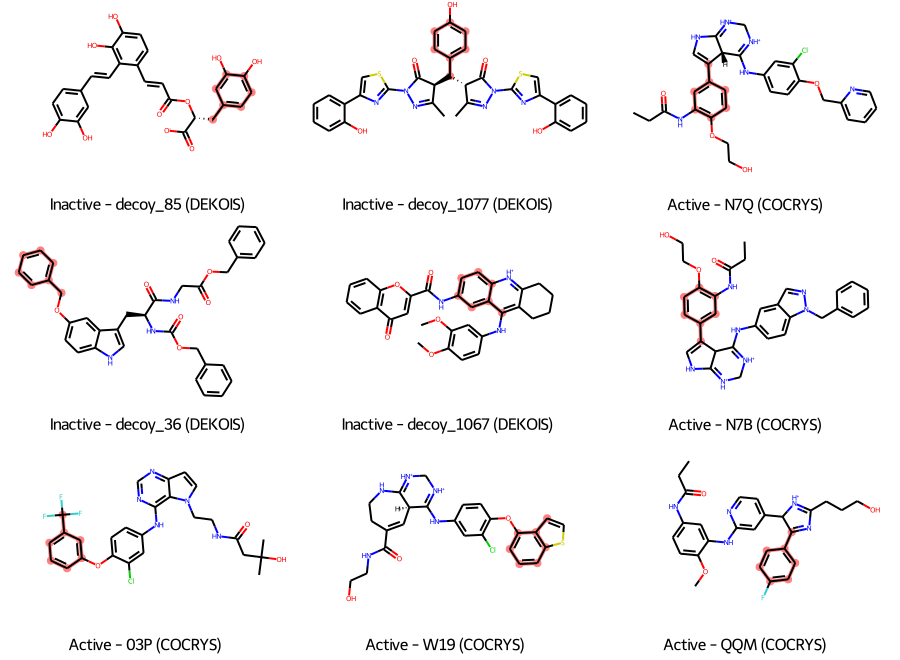

\begin{tabular}{lllrrrrrrrr}
\toprule
       &     &  Activity &    LR &  GBT &  csAVG &  csGEOM &  csMIN &     MW &  num\_atoms &  num\_rot \\
Library & Lig. Name &           &       &      &        &         &        &        &            &          \\
\midrule
DEKOIS & decoy\_85 &  Inactive &  1722 &  243 &      1 &       2 &      3 &  493.4 &         36 &        8 \\
       & decoy\_1077 &  Inactive &   205 &  310 &      2 &       1 &     19 &  650.7 &         46 &        7 \\
COCRYS & N7Q &    Active &  1511 &  215 &      3 &       3 &      6 &  563.1 &         40 &       10 \\
DEKOIS & decoy\_36 &  Inactive &  4575 &  546 &      4 &       4 &     14 &  591.7 &         44 &       13 \\
       & decoy\_1067 &  Inactive &   273 &  261 &      5 &       5 &     50 &  522.6 &         39 &        6 \\
COCRYS & N7B &    Active &  2084 &  250 &      6 &       8 &      7 &  551.7 &         41 &        9 \\
       & 03P &    Active &  1517 &  313 &      7 &       9 &      8 &  548.0 &      

In [41]:
# Define the method
method = 'csAVG'
n_mols = 9

img, df_top = draw_top_mols_by_method(method, n_mols=n_mols)

display(df_top)
display(img)

# Save for supplementary material
filename = f'{protein_name}_{n_mols}_topMols_{method}.svg'
with open(filename, 'w') as f:
    f.write(img.data)
    
print(df_top.round(1).to_latex())

### Min Consensus strategy (csMIN)

Activity     LR  GBT  csAVG  csGEOM  csMIN       MW  \
Library Lig. Name                                                        
COCRYS  ITI          Active  12475  478     38      40      1  588.717   
        W19          Active    333  426      8       6      2  512.035   
        FMM          Active   1272  365     10      17      3  582.077   
DEKOIS  decoy_85   Inactive   1722  243      1       2      3  493.444   
        decoy_136  Inactive    515  701    249     305      5  530.718   
COCRYS  N7Q          Active   1511  215      3       3      6  563.058   
        N7B          Active   2084  250      6       8      7  551.651   
        03P          Active   1517  313      7       9      8  547.965   
        W32          Active    460  247     13      14      9  586.036   

                   num_atoms  num_rot  
Library Lig. Name                      
COCRYS  ITI               43        7  
        W19               35        6  
        FMM               40       11  
DEKOIS  decoy_85          36        8  
        decoy_136         38       12  
COCRYS  N7Q               40       10  
        N7B               41        9  
        03P               38        9  
        W32               39        7

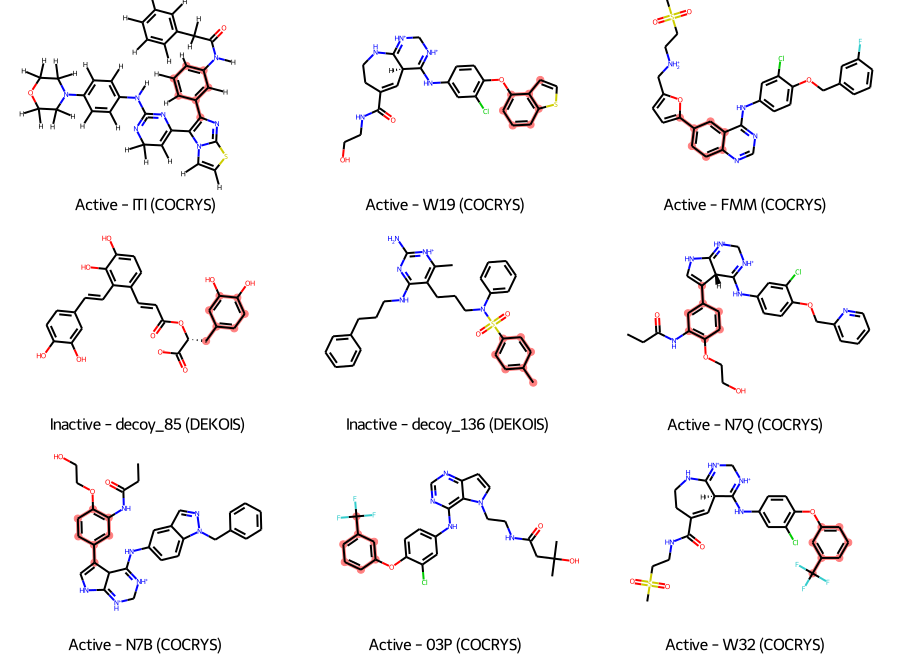

\begin{tabular}{lllrrrrrrrr}
\toprule
       &     &  Activity &     LR &  GBT &  csAVG &  csGEOM &  csMIN &     MW &  num\_atoms &  num\_rot \\
Library & Lig. Name &           &        &      &        &         &        &        &            &          \\
\midrule
COCRYS & ITI &    Active &  12475 &  478 &     38 &      40 &      1 &  588.7 &         43 &        7 \\
       & W19 &    Active &    333 &  426 &      8 &       6 &      2 &  512.0 &         35 &        6 \\
       & FMM &    Active &   1272 &  365 &     10 &      17 &      3 &  582.1 &         40 &       11 \\
DEKOIS & decoy\_85 &  Inactive &   1722 &  243 &      1 &       2 &      3 &  493.4 &         36 &        8 \\
       & decoy\_136 &  Inactive &    515 &  701 &    249 &     305 &      5 &  530.7 &         38 &       12 \\
COCRYS & N7Q &    Active &   1511 &  215 &      3 &       3 &      6 &  563.1 &         40 &       10 \\
       & N7B &    Active &   2084 &  250 &      6 &       8 &      7 &  551.7 &         41 

In [42]:
# Define the method
method = 'csMIN'
n_mols = 9

img, df_top = draw_top_mols_by_method(method, n_mols=n_mols)

display(df_top)
display(img)


# Save for supplementary material
filename = f'{protein_name}_{n_mols}_topMols_{method}.svg'
with open(filename, 'w') as f:
    f.write(img.data)
    
print(df_top.round(1).to_latex())